# Analysis of minimal pairs and homophones


In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import statsmodels.formula.api as sm
import seaborn as sns
from tqdm import tqdm

import src.utils as utils
import src.config as config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Pipeline

Here, we define the general pipeline to analyze pre-processed lexicons (real and artificial).

In [3]:
NUM_ARTIFICIAL = 10

In [4]:
def get_stats_for_lexicon(df_lex):
    """Return basic stats about lexicon. Number of homophones, etc."""
    return {'homophone_percentage': round((len(df_lex[df_lex['num_homophones']>0]) / len(df_lex)), 4),
            'mean_homophones': round(df_lex['num_homophones'].mean(), 4),
            'max_homophones': round(df_lex['num_homophones'].max(), 2),
            'mean_mp': round(df_lex['neighborhood_size'].mean(), 4),
            'max_mp': round(df_lex['neighborhood_size'].max(), 2),
            'total_mp': round(df_lex['neighborhood_size'].sum(), 2),
            'mean_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].mean(), 4),
            'max_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].max(), 2),
            'total_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].sum(), 2)}

In [5]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    # Neighborhood size with homophones
    mean_mp_hp, max_mp_hp, total_mp_hp = [], [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                          phon_column="word", word_column="word")
        
        lex_stats = get_stats_for_lexicon(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
        mean_mp.append(lex_stats['mean_mp'])
        max_mp.append(lex_stats['max_mp'])
        total_mp.append(lex_stats['total_mp'])
        mean_mp_hp.append(lex_stats['mean_mp_w_hp'])
        max_mp_hp.append(lex_stats['max_mp_w_hp'])
        total_mp_hp.append(lex_stats['total_mp_w_hp'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones,
            'mean_mp': mean_mp,
            'max_mp': max_mp,
            'total_mp': total_mp,
            'mean_mp_w_hp': mean_mp_hp,
            'max_mp_w_hp': max_mp_hp,
            'total_mp_w_hp': total_mp_hp
           }
    

In [6]:
def plot_real_vs_art(art_dist, real_value, statistic, language, ylabel="Count"):
    """Compare distribution of test statistics from artificial lexicon to real lexicon."""
    
    print("Mean of artificial: {x}.".format(x=statistics.mean(art_dist)))
    print("Median of artificial: {x}.".format(x=statistics.median(art_dist)))
    print("Standard deviation of artificial: {x}.".format(x=statistics.stdev(art_dist)))
    print("Range of artificial: ({x}, {y}).".format(x=min(art_dist), y=max(art_dist)))
    print("Real value: {x}.".format(x=real_value))
    
    plt.hist(art_dist)
    plt.title("{lan}: {x} (real vs. artificial)".format(lan=language, x=statistic))
    plt.xlabel(statistic)
    plt.ylabel(ylabel)
    plt.axvline(x=real_value, linestyle="dotted", color="red")
    # plt.axvline(x=0, linestyle="dashed", color="blue")

In [7]:
def load_lexicons_for_language(language, phon_column="PhonDISC", word_column="Word"):
    """Loads lexicons for a given language."""
    df_real = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_all_mps.csv".format(lan1=language,
                                                                                         lan2=language))
    df_real_processed = utils.preprocess_for_analysis(df_real, word_column=word_column, phon_column=phon_column)
    df_artificials = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_artificial_10_matched_on_sylls_mps_no_restriction.csv".format(lan1=language,
                                                                                                                           lan2=language))
    return df_real, df_real_processed, df_artificials
    

In [8]:
def analyze_stats(df_og, list_of_artificials, formula, covariates):
    """Analyze stats for real vs artificial dataframes."""
    result_real = sm.poisson(formula=formula, 
                data=df_og).fit(disp=0)
    
    params = result_real.params
    params['real'] = "Yes"
    real_r2 = result_real.prsquared
    params['pr2'] = real_r2
    
    coefs = []
    coefs.append(params)
    
    for df_art in list_of_artificials:
        result_fake = sm.poisson(formula=formula, 
                data=df_art).fit(disp=0)
        fake_r2 = result_fake.prsquared
        params = result_fake.params
        params['real'] = "No"
        params['pr2'] = fake_r2
        coefs.append(params)
    
    return pd.DataFrame(coefs)

## English

In [105]:
df_celex, df_celex_processed, df_english_artificials = load_lexicons_for_language("english")

In [106]:
len(df_celex)

52438

In [107]:
len(df_celex_processed)

35107

In [108]:
df_english_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [109]:
info_for_english = process_and_extract_artificials(df_english_artificials)

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


In [110]:
processed_artificials = info_for_english['processed_dataframes']

#### Norm surprisal

In [111]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

### `#homophones` ~ `rank_homophones`

In [31]:
rank_N = 1000

In [32]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

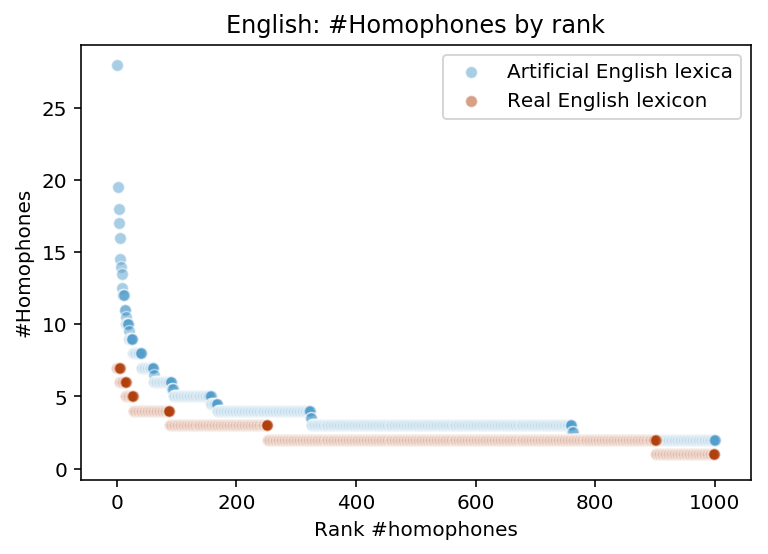

In [36]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial English lexica")

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real English lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("English: #Homophones by rank")

plt.savefig("Figures/english/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

In [112]:
rank_N = 1000

In [113]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

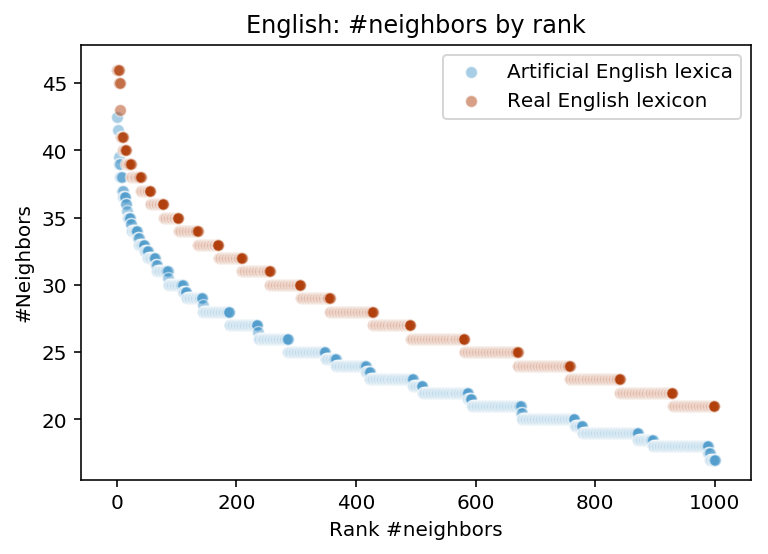

In [114]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial English lexica")

df_celex_processed['rank_num'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real English lexicon")
plt.xlabel("Rank #neighbors")
plt.ylabel("#Neighbors")
plt.title("English: #neighbors by rank")

plt.savefig("Figures/english/data_visualizations/rank_neighbors.png", dpi=300)

# German

In [40]:
df_celex, df_celex_processed, df_german_artificials = load_lexicons_for_language("german")

/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


In [41]:
len(df_celex)

51719

In [42]:
len(df_celex_processed)

50474

In [43]:
df_german_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [44]:
info_for_german = process_and_extract_artificials(df_german_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


In [45]:
processed_artificials = info_for_german['processed_dataframes']

#### Norm surprisal

In [46]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

In [47]:
rank_N = 1000

In [48]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

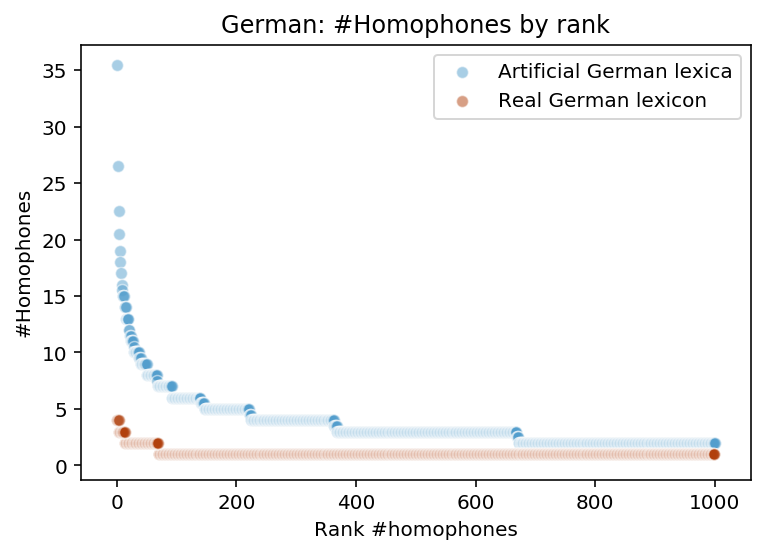

In [49]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial German lexica")

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real German lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("German: #Homophones by rank")

plt.savefig("Figures/german/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

In [50]:
rank_N = 1000

In [51]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

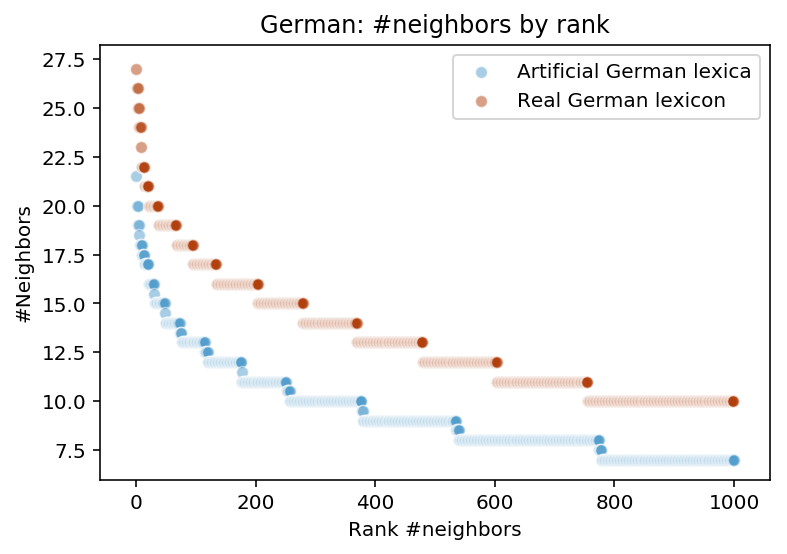

In [52]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial German lexica")

df_celex_processed['rank_num'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real German lexicon")
plt.xlabel("Rank #neighbors")
plt.ylabel("#Neighbors")
plt.title("German: #neighbors by rank")

plt.savefig("Figures/english/data_visualizations/rank_neighbors.png", dpi=300)

# Dutch

In [82]:
df_celex, df_celex_processed, df_dutch_artificials = load_lexicons_for_language("dutch")

In [83]:
len(df_celex)

67910

In [84]:
len(df_celex_processed)

65351

In [85]:
df_dutch_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [86]:
info_for_dutch = process_and_extract_artificials(df_dutch_artificials)

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


In [87]:
processed_artificials = info_for_dutch['processed_dataframes']

In [88]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

In [89]:
rank_N = 1000

In [90]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

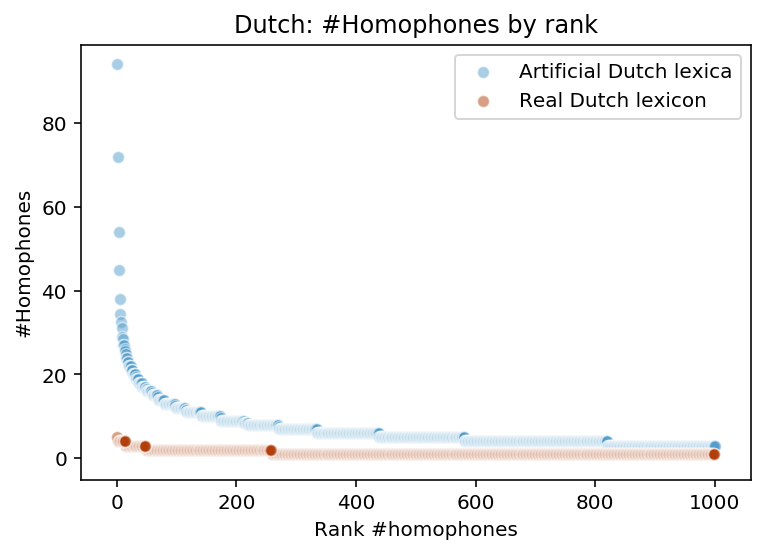

In [91]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Dutch lexica")

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Dutch lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("Dutch: #Homophones by rank")

plt.savefig("Figures/dutch/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

In [64]:
rank_N = 1000

In [65]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

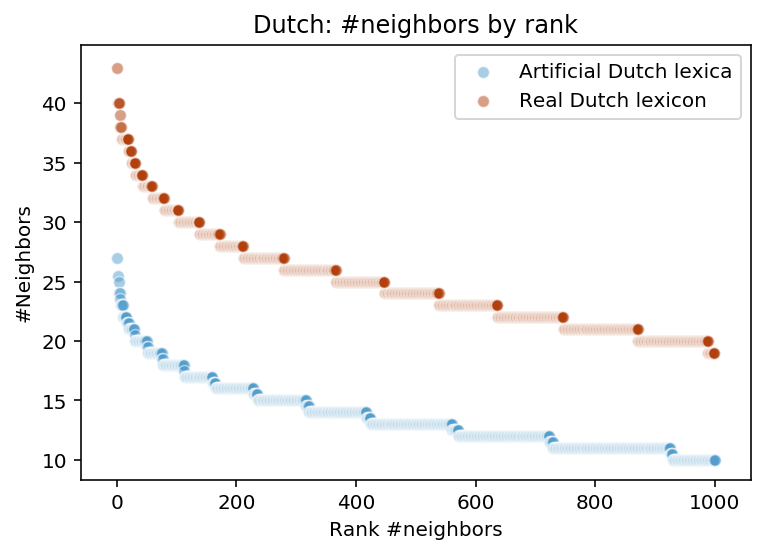

In [66]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Dutch lexica")

df_celex_processed['rank_num'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Dutch lexicon")
plt.xlabel("Rank #neighbors")
plt.ylabel("#Neighbors")
plt.title("Dutch: #neighbors by rank")

plt.savefig("Figures/dutch/data_visualizations/rank_neighbors.png", dpi=300)

# French

In [67]:
import src.config as config

In [68]:
df_celex, df_celex_processed, df_french_artificials = load_lexicons_for_language("french", 
                                                                                word_column=config.WORD_COLUMN['french'], 
                                                                                phon_column=config.PHON_COLUMN['french'])

In [69]:
len(df_celex)

47310

In [70]:
len(df_celex_processed)

37278

In [71]:
df_french_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [72]:
info_for_french = process_and_extract_artificials(df_french_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


In [73]:
processed_artificials = info_for_french['processed_dataframes']

In [74]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

In [75]:
rank_N = 1000

In [76]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

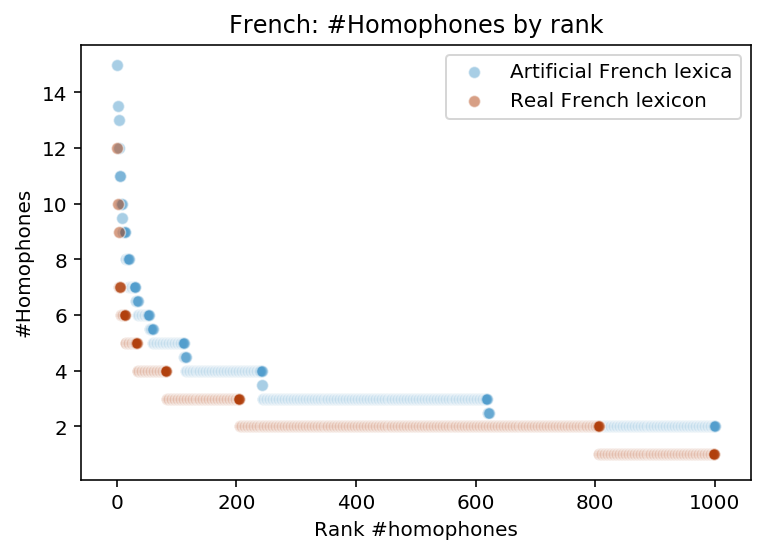

In [78]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial French lexica")

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real French lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("French: #Homophones by rank")

plt.savefig("Figures/french/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

In [79]:
rank_N = 1000

In [80]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

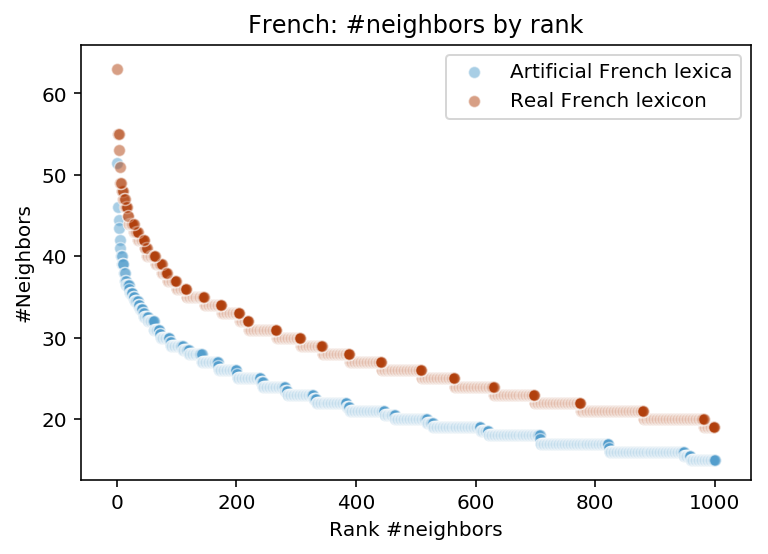

In [81]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial French lexica")

df_celex_processed['rank_num'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real French lexicon")
plt.xlabel("Rank #neighbors")
plt.ylabel("#Neighbors")
plt.title("French: #neighbors by rank")

plt.savefig("Figures/french/data_visualizations/rank_neighbors.png", dpi=300)

## Japanese

In [92]:
df_celex, df_celex_processed, df_japanese_artificials = load_lexicons_for_language("japanese", phon_column="phonetic_remapped",
                                                                                 word_column="orth_form_romaji")

In [93]:
len(df_celex)

51147

In [94]:
len(df_celex_processed)

40449

In [95]:
df_japanese_stats = get_stats_for_lexicon(df_celex_processed)
df_japanese_stats

{'homophone_percentage': 0.1506,
 'mean_homophones': 0.2645,
 'max_homophones': 33,
 'mean_mp': 4.7489,
 'max_mp': 59,
 'total_mp': 192090,
 'mean_mp_w_hp': 9.4683,
 'max_mp_w_hp': 356,
 'total_mp_w_hp': 382984}

### Preprocess artificials

In [96]:
info_for_japanese = process_and_extract_artificials(df_japanese_artificials)

100%|██████████| 10/10 [00:08<00:00,  1.27it/s]


In [97]:
processed_artificials = info_for_japanese['processed_dataframes']

In [98]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

In [99]:
rank_N = 1000

In [100]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

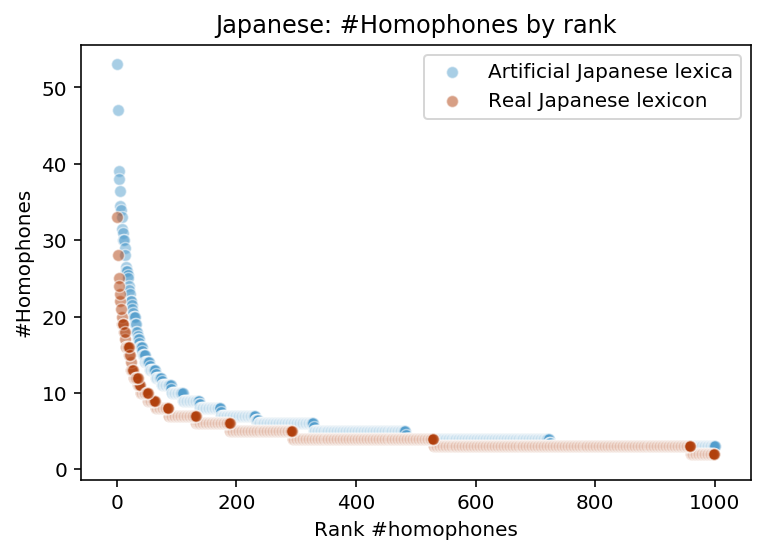

In [101]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Japanese lexica")

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Japanese lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("Japanese: #Homophones by rank")

plt.savefig("Figures/japanese/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

In [102]:
rank_N = 1000

In [103]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

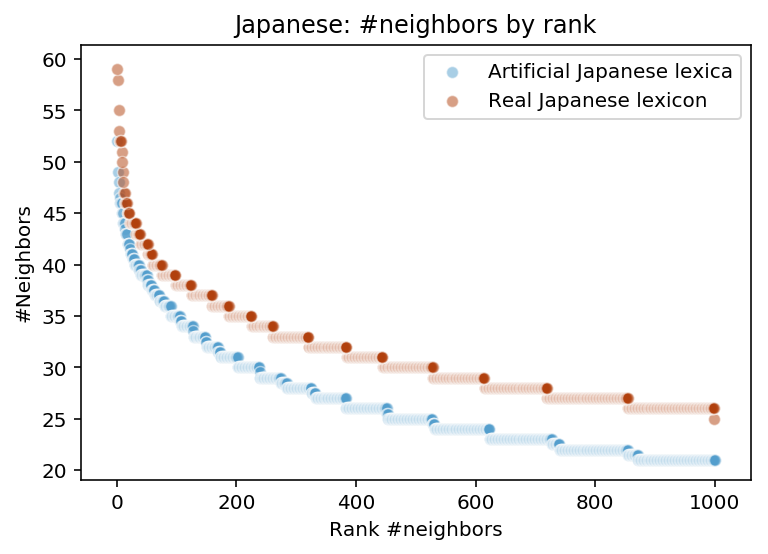

In [104]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Japanese lexica")

df_celex_processed['rank_num'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Japanese lexicon")
plt.xlabel("Rank #neighbors")
plt.ylabel("#Neighbors")
plt.title("Japanese: #neighbors by rank")

plt.savefig("Figures/japanese/data_visualizations/rank_neighbors.png", dpi=300)

## Chinese

In [20]:
def process_and_extract_artificials_2(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    # Neighborhood size with homophones
    mean_mp_hp, max_mp_hp, total_mp_hp = [], [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                          phon_column="word", word_column="word")
        
        lex_stats = utils.get_homophone_stats(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones,
           }
    

In [105]:
# df_celex, df_celex_processed, df_english_artificials = load_lexicons_for_language("english")

In [17]:
df_og = pd.read_csv("data/processed/mandarin/mandarin_all_reals_5phone.csv")
df_main_processed = pd.read_csv("data/processed/mandarin/mandarin_lemmas_processed_5phone.csv")
df_mandarin_artificials = pd.read_csv("data/processed/mandarin/mandarin_artificial_10_matched_on_sylls_no_restriction_5phone.csv")


In [14]:
len(df_og)

91662

In [15]:
len(df_main_processed)

82522

In [18]:
# df_mandarin_stats = get_stats_for_lexicon(df_celex_processed)

df_mandarin_stats = utils.get_homophone_stats(df_main_processed)
df_mandarin_stats

{'homophone_percentage': 0.0675,
 'mean_homophones': 0.1108,
 'max_homophones': 41}

### Preprocess artificials

In [22]:
info_for_mandarin = process_and_extract_artificials_2(df_mandarin_artificials)

  0%|          | 0/10 [00:00<?, ?it/s]

Number of tokens: 91662
Number of tokens: 15546


 10%|█         | 1/10 [00:00<00:02,  3.04it/s]

Number of tokens: 917
Number of tokens: 91662
Number of tokens: 15435


 20%|██        | 2/10 [00:00<00:02,  3.13it/s]

Number of tokens: 918
Number of tokens: 91662
Number of tokens: 15265


 30%|███       | 3/10 [00:00<00:02,  3.06it/s]

Number of tokens: 902
Number of tokens: 91662
Number of tokens: 15304


 40%|████      | 4/10 [00:01<00:01,  3.13it/s]

Number of tokens: 914
Number of tokens: 91662
Number of tokens: 15390


 50%|█████     | 5/10 [00:01<00:01,  3.03it/s]

Number of tokens: 913
Number of tokens: 91662
Number of tokens: 15481


 60%|██████    | 6/10 [00:01<00:01,  3.11it/s]

Number of tokens: 895
Number of tokens: 91662
Number of tokens: 15239


 70%|███████   | 7/10 [00:02<00:01,  2.88it/s]

Number of tokens: 930
Number of tokens: 91662
Number of tokens: 15385


 80%|████████  | 8/10 [00:02<00:00,  3.01it/s]

Number of tokens: 925
Number of tokens: 91662
Number of tokens: 15340


 90%|█████████ | 9/10 [00:02<00:00,  3.07it/s]

Number of tokens: 910
Number of tokens: 91662
Number of tokens: 15298


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]

Number of tokens: 936


In [23]:
processed_artificials = info_for_mandarin['processed_dataframes']

#### Norm surprisal

In [25]:
df_main_processed['surprisal_normed'] = df_main_processed['surprisal'] / df_main_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

### `#homophones` ~ `rank_homophones`

In [26]:
rank_N = 1000

In [27]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

IndexError: list index out of range

In [37]:
df_stats = pd.DataFrame(stats)

In [35]:
df_main_processed['rank_num'] = df_main_processed['num_homophones'].rank(ascending=False, method="first")

Text(0.5, 1.0, 'Mandarin: #Homophones by rank')

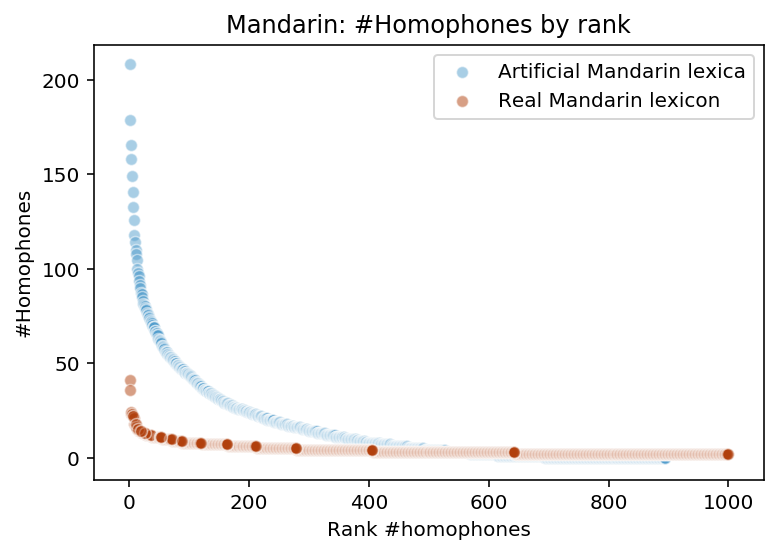

In [38]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Mandarin lexica")

sns.scatterplot(data = df_main_processed[df_main_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Mandarin lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("Mandarin: #Homophones by rank")

# plt.savefig("Figures/english/data_visualizations/rank_homophones.png", dpi=300)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2d2c7668>]],
      dtype=object)

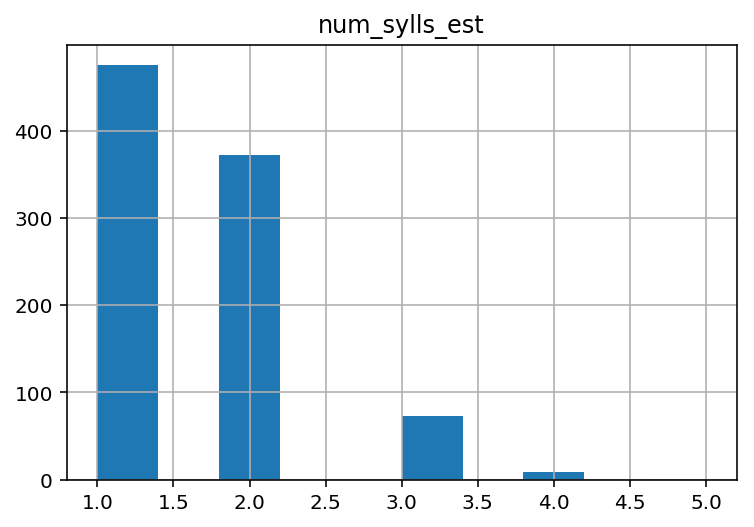

In [50]:
df_m1 = processed_artificials[6]
df_m1.hist(column='num_sylls_est')

In [55]:
r = sm.poisson(data = df_m1,
              formula="num_homophones ~ surprisal_normed + num_sylls_est").fit()
r.summary()

Optimization terminated successfully.
         Current function value: 8.470986
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:         num_homophones   No. Observations:                  930
Model:                        Poisson   Df Residuals:                      927
Method:                           MLE   Df Model:                            2
Date:                Mon, 20 Jan 2020   Pseudo R-squ.:                  0.4413
Time:                        16:15:41   Log-Likelihood:                -7878.0
converged:                       True   LL-Null:                       -14101.
                                        LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.8586      0.046    126.171      0.000       5.768       5.950
surprisal_normed    -4.4368      0.053    -84.115      0.000      -4.540      -4.333
num_sylls_est        0.3285      0.012     26.750      0.000       0.304       0.353
====================================================================================
"""

In [56]:
r = sm.poisson(data = df_main_processed,
              formula="num_homophones ~ surprisal_normed + num_sylls_est").fit()
r.summary()

Optimization terminated successfully.
         Current function value: 0.363427
         Iterations 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:         num_homophones   No. Observations:                82522
Model:                        Poisson   Df Residuals:                    82519
Method:                           MLE   Df Model:                            2
Date:                Mon, 20 Jan 2020   Pseudo R-squ.:                  0.1152
Time:                        16:15:46   Log-Likelihood:                -29991.
converged:                       True   LL-Null:                       -33896.
                                        LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.3318      0.040    -58.316      0.000      -2.410      -2.253
surprisal_normed     2.2679      0.033     69.662      0.000       2.204       2.332
num_sylls_est       -0.5150      0.010    -52.239      0.000      -0.534      -0.496
====================================================================================
"""

# Concatenating all languages together

For convenience, the code below runs the primary analyses on each language to build a summary table of the main findings.

In [9]:
languages = ['english', 'german', 'dutch', 'french', 'japanese']

In [10]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

# Adding minimal pairs
TARGET_MODEL_2 = 'num_homophones'
COVARIATES_MODEL_2 = [
    'surprisal_normed',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA_MODEL_2 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_2, regressors=' + '.join(COVARIATES_MODEL_2))

# Predicting minimal pairs
TARGET_MODEL_3 = 'neighborhood_size'
COVARIATES_MODEL_3 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_3 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_3, regressors=' + '.join(COVARIATES_MODEL_3))


In [11]:
#Supplementary models: non-normed surprisal
TARGET_MODEL_4 = 'num_homophones'
COVARIATES_MODEL_4 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_4 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_4, regressors=' + '.join(COVARIATES_MODEL_4))

# Adding minimal pairs
TARGET_MODEL_5 = 'num_homophones'
COVARIATES_MODEL_5 = [
    'surprisal',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA_MODEL_5 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_5, regressors=' + '.join(COVARIATES_MODEL_5))

# Predicting minimal pairs
TARGET_MODEL_6 = 'neighborhood_size'
COVARIATES_MODEL_6 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_6 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_6, regressors=' + '.join(COVARIATES_MODEL_6))


In [12]:
model1_results, model2_results, model3_results = [], [], []
model4_results, model5_results, model6_results = [], [], []
descriptive_stats = []

for language in languages:
    print(language)
    phon_column = config.PHON_COLUMN[language]
    word_column = config.WORD_COLUMN[language]
    df_og, df_processed, df_artificials = load_lexicons_for_language(language, phon_column=phon_column,
                                                                     word_column=word_column)

    # Process artificial lexica
    language_info = process_and_extract_artificials(df_artificials)
    processed_artificials = language_info.pop('processed_dataframes')
    
    # Create normed surprisal column
    df_processed['surprisal_normed'] = df_processed['surprisal'] / df_processed['num_phones']
    for p in processed_artificials:
        p['surprisal_normed'] = p['surprisal'] / p['num_phones']
        
    ####### Get descriptive statistics #######
    stats_real = get_stats_for_lexicon(df_processed)
    stats_real['language'] = language
    stats_real['real'] = "Yes"
    descriptive_stats.append(pd.DataFrame([stats_real]))
    
    # Add descriptive statistics from artificial lexica
    simulated_stats = pd.DataFrame(language_info)
    simulated_stats['language'] = [language for i in range(len(simulated_stats))]
    simulated_stats['real'] = ["No" for i in range(len(simulated_stats))]
    descriptive_stats.append(simulated_stats)
    
    ####### Statistical modeling #######
    
    # Run model 1
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_1, 
                                covariates=COVARIATES_MODEL_1)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 1 data
    model1_results.append(df_analysis)
    
    # Run model 2
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_2, 
                                covariates=COVARIATES_MODEL_2)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 2 data
    model2_results.append(df_analysis)

    # Run model 3
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_3, 
                                covariates=COVARIATES_MODEL_3)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 3 data
    model3_results.append(df_analysis)
    
    ##### Supplementary (non-normalized surprisal)
    
    # Run model 4
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_4, 
                                covariates=COVARIATES_MODEL_4)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 4 data
    model4_results.append(df_analysis)

    # Run model 5
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_5, 
                                covariates=COVARIATES_MODEL_5)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 5 data
    model5_results.append(df_analysis)

    # Run model 6
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_6, 
                                covariates=COVARIATES_MODEL_6)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 6 data
    model6_results.append(df_analysis)

english


/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)
100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


german


100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


dutch


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


french


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


japanese


100%|██████████| 10/10 [00:07<00:00,  1.22it/s]


## Descriptive results

### Homophony

In [13]:
df_descriptive = pd.concat(descriptive_stats)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


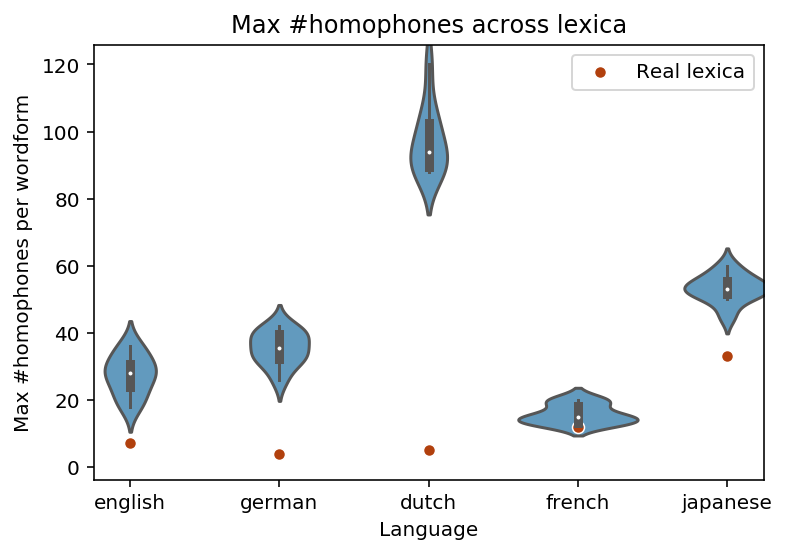

In [14]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'max_homophones',
           # palette = 'Blues',
            color = sns.color_palette("Blues")[3],
               label = "Simulated"
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
                   x = "language",
                   y = 'max_homophones',
                   color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
    
plt.title("Max #homophones across lexica")
plt.ylabel("Max #homophones per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/max_homophones.png", dpi=400, bbox_inches = "tight")

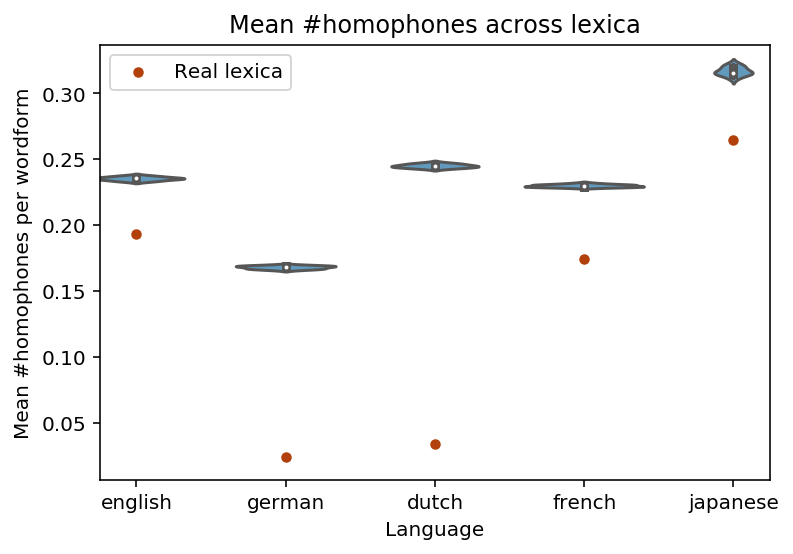

In [15]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'mean_homophones',
           # palette = 'Blues',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
                   x = "language",
           y = 'mean_homophones',
                   color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
    
plt.title("Mean #homophones across lexica")
plt.ylabel("Mean #homophones per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/mean_homophones.png", dpi=400, bbox_inches = "tight")

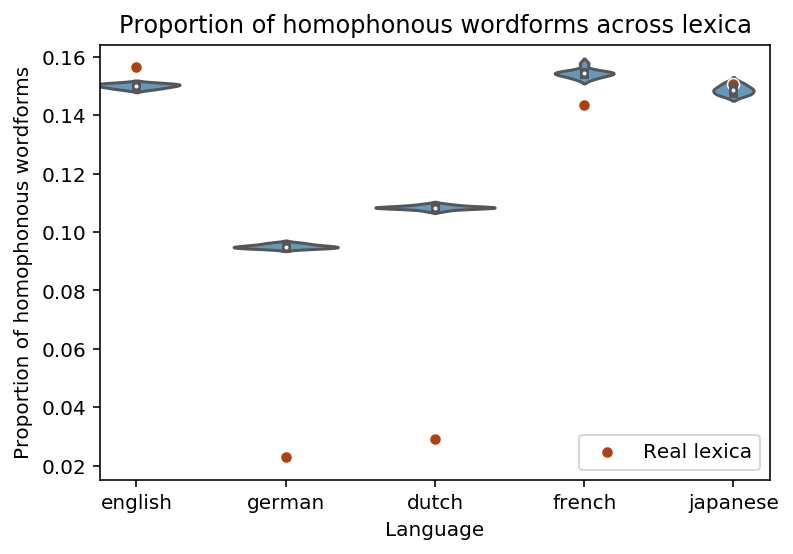

In [16]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'homophone_percentage',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'homophone_percentage',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Proportion of homophonous wordforms across lexica")
plt.ylabel("Proportion of homophonous wordforms")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/homophony_rate.png", dpi=400, bbox_inches = "tight")

### Minimal pairs

In [17]:
df_descriptive[(df_descriptive['language']=='japanese')&(df_descriptive['real']=="No")].describe()

,homophone_percentage,max_homophones,max_mp,max_mp_w_hp,mean_homophones,mean_mp,mean_mp_w_hp,total_mp,total_mp_w_hp
count,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.148740,53.200000,51.60000,393.100000,0.316910,3.599330,8.248410,139795.000000,320355.100000
std,0.001508,4.104198,1.95505,14.129952,0.003245,0.031211,0.054912,1439.913655,1982.708834
min,0.146900,45.000000,48.00000,378.000000,0.311600,3.547300,8.155300,137252.000000,317324.000000
25%,0.147500,51.500000,50.25000,385.250000,0.315050,3.586075,8.221500,139046.500000,319152.250000
50%,0.148750,53.000000,52.00000,387.000000,0.315800,3.597800,8.255950,139880.000000,320704.500000
75%,0.149600,55.500000,52.75000,398.750000,0.319050,3.615525,8.284075,140684.000000,321221.250000
max,0.151200,60.000000,55.00000,425.000000,0.321900,3.644600,8.338000,141772.000000,324098.000000


In [18]:
df_descriptive[(df_descriptive['language']=='japanese')&(df_descriptive['real']=="Yes")]

,homophone_percentage,language,max_homophones,max_mp,max_mp_w_hp,mean_homophones,mean_mp,mean_mp_w_hp,real,total_mp,total_mp_w_hp
0,0.1506,japanese,33,59,356,0.2645,4.7489,9.4683,Yes,192090,382984


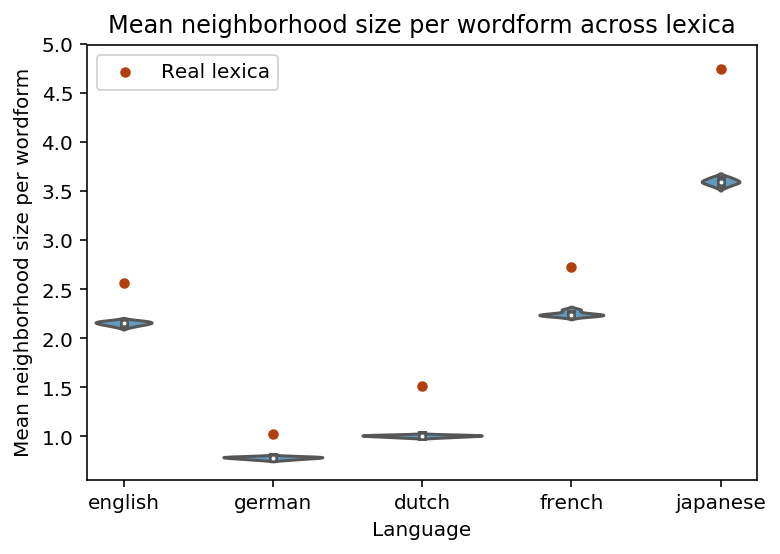

In [19]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'mean_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'mean_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Mean neighborhood size per wordform across lexica")
plt.ylabel("Mean neighborhood size per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/mean_mps.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Language')

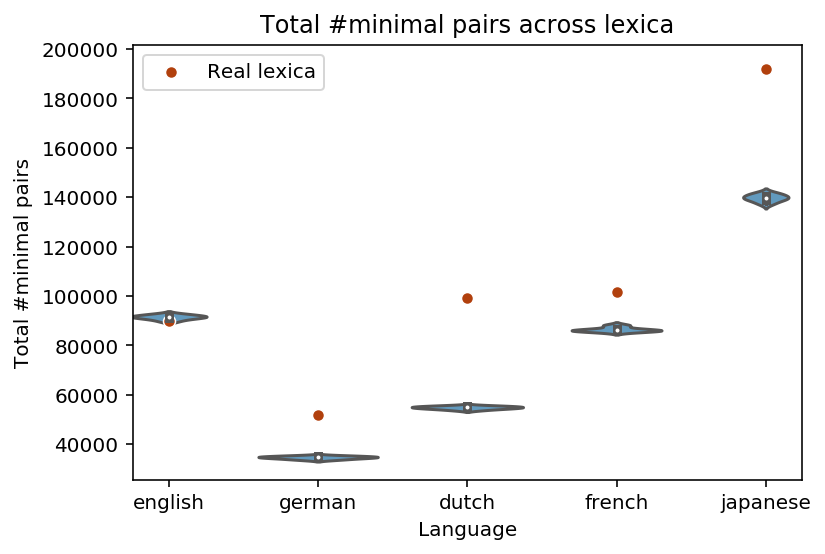

In [20]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'total_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'total_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Total #minimal pairs across lexica")
plt.ylabel("Total #minimal pairs")
plt.xlabel("Language")
# plt.savefig("Figures/combined/descriptive/total_mps.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Language')

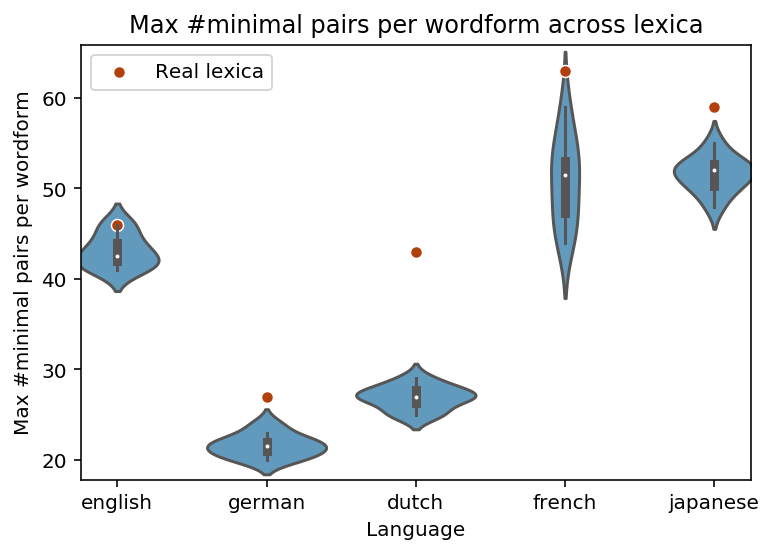

In [21]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'max_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'max_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Max #minimal pairs per wordform across lexica")
plt.ylabel("Max #minimal pairs per wordform")
plt.xlabel("Language")
# plt.savefig("Figures/combined/descriptive/max_mps.png", dpi=400, bbox_inches = "tight")

## Modeling results

### Model 1: `#homophones ~ #syllables + surprisal`

In [22]:
df_all_model1 = pd.concat(model1_results)

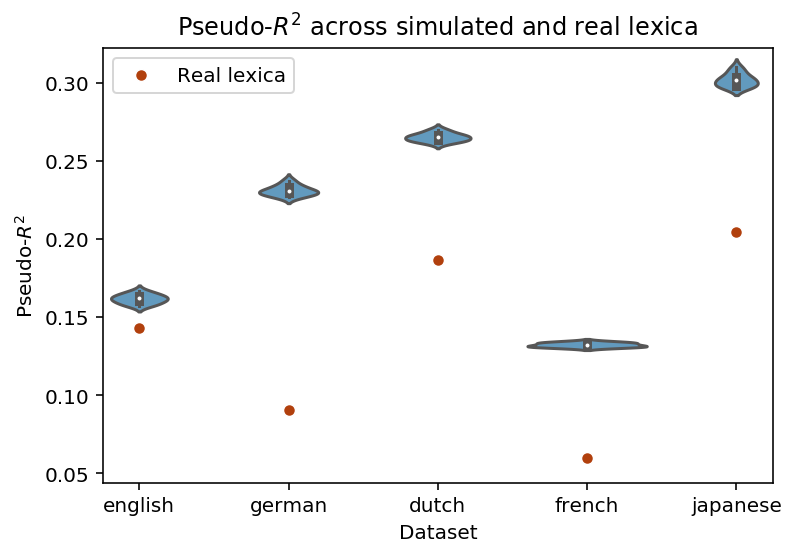

In [23]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_r2.png", dpi=400, bbox_inches = "tight")

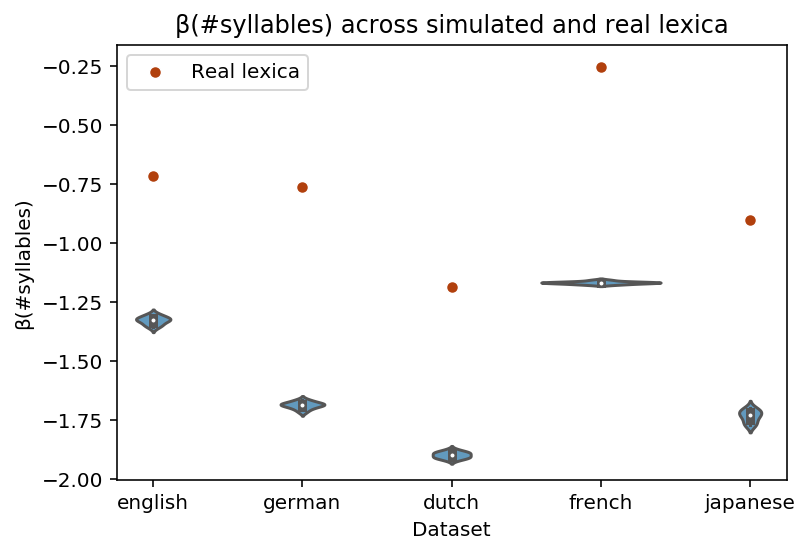

In [24]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_#sylls.png", dpi=400, bbox_inches = "tight")

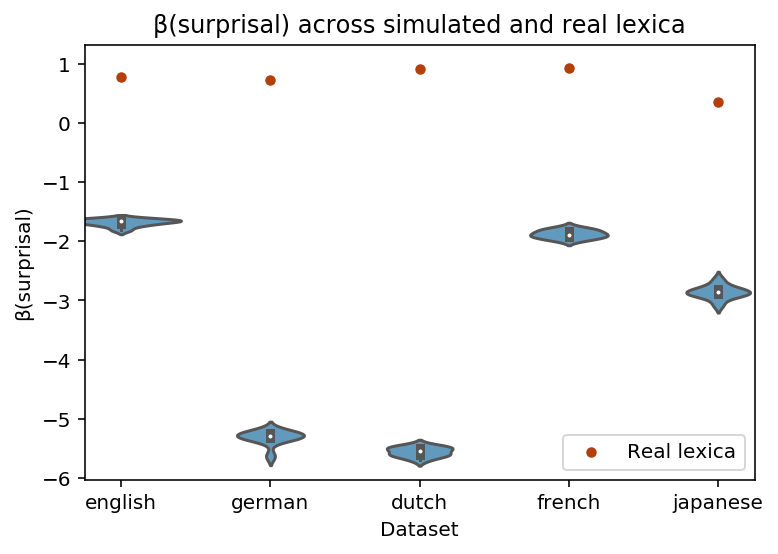

In [26]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'surprisal_normed',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'surprisal_normed',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_surprisal.png", dpi=400, bbox_inches = "tight")

### Model 2: `#minimal pairs ~ #syllables + surprisal`

In [67]:
df_all_model3 = pd.concat(model3_results)

Text(0.5, 0, 'Dataset')

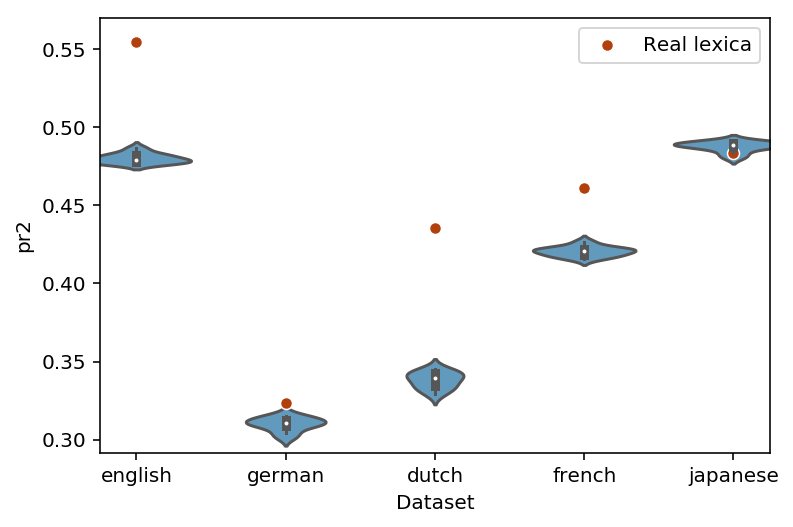

In [87]:
sns.violinplot(data = df_all_model3[df_all_model3['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model3[df_all_model3['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
# plt.title("\u03B2(#minimal pairs) across simulated and real lexica")
# plt.ylabel("\u03B2(#minimal pairs)")
plt.xlabel("Dataset")
# plt.savefig("Figures/combined/modeling/model2_mps.png", dpi=400, bbox_inches = "tight")

## Supplementary models

### Model 3: `#homophones ~ #syllables + surprisal`

In [92]:
df_all_model4 = pd.concat(model4_results)

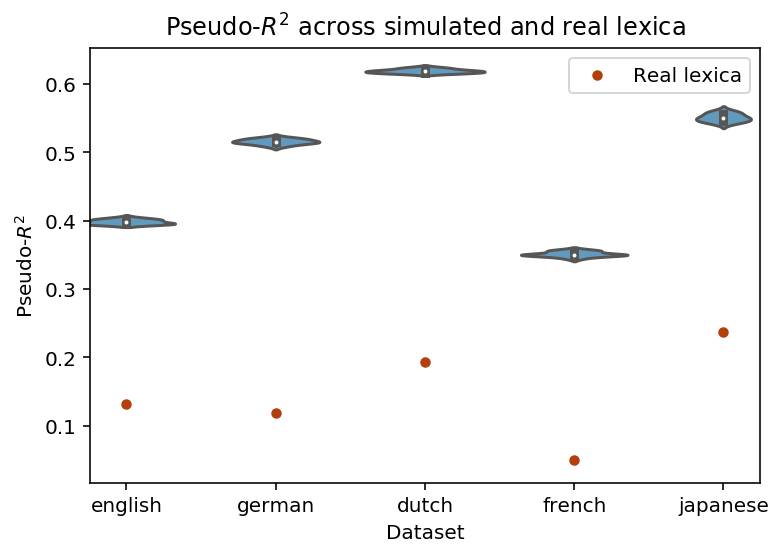

In [94]:
sns.violinplot(data = df_all_model4[df_all_model4['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model4[df_all_model4['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model4_r2.png", dpi=400, bbox_inches = "tight")

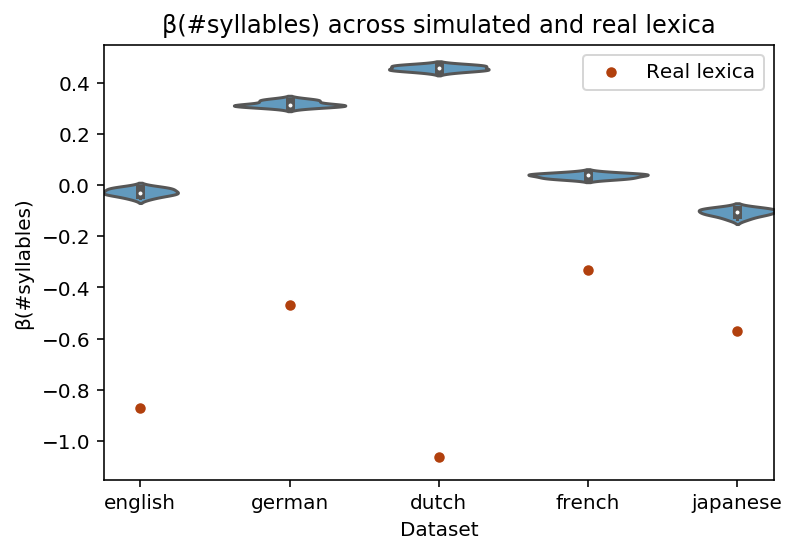

In [102]:
sns.violinplot(data = df_all_model4[df_all_model4['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model4[df_all_model4['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model4_#sylls.png", dpi=400, bbox_inches = "tight")

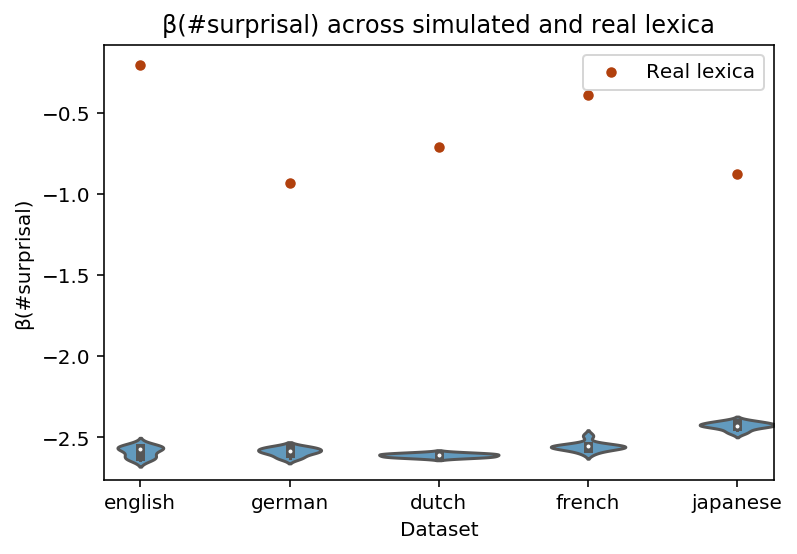

In [99]:
sns.violinplot(data = df_all_model4[df_all_model4['real']=="No"],
           x = "language",
           y = 'surprisal',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model4[df_all_model4['real']=="Yes"],
           x = "language",
           y = 'surprisal',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(#surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model4_surprisal.png", dpi=400, bbox_inches = "tight")

# Supplementary analyses: biphone model

## English

In [18]:
df_real = pd.read_csv("data/processed/english/english_all_reals_2phone.csv")
df_lemmas = pd.read_csv("data/processed/english/english_lemmas_processed_2phone.csv")
df_artificials = pd.read_csv("data/processed/english/english_artificial_10_matched_on_sylls_no_restriction_2phone.csv")


In [48]:
english_stats = utils.get_homophone_stats(df_lemmas)

### Preprocess artificials

In [25]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                          phon_column="word", word_column="word")
        
        lex_stats = utils.get_homophone_stats(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones
           }
    

In [26]:
info_for_english = process_and_extract_artificials(df_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


In [27]:
processed_artificials = info_for_english['processed_dataframes']

#### Norm surprisal

In [29]:
df_lemmas['surprisal_normed'] = df_lemmas['surprisal'] / df_lemmas['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Descriptive

In [61]:
max_m = round(np.mean(info_for_english['max_homophones']), 2)
max_std = round(np.std(info_for_english['max_homophones']), 3)
print("Max homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = max_m, max_std=max_std))
print("Real: {m}".format(m = english_stats['max_homophones']))

Max homophony: 
Artificial: M = 434.3, SD = 26.272
Real: 7


In [60]:
mean_m = round(np.mean(info_for_english['mean_homophones']), 2)
mean_std = round(np.std(info_for_english['mean_homophones']), 3)
print("Mean homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = mean_m, max_std=mean_std))
print("Real: {m}".format(m = english_stats['mean_homophones']))

Mean homophony: 
Artificial: M = 0.13, SD = 0.001
Real: 0.1931


In [64]:
prop_m = round(np.mean(info_for_english['homophone_percentage']), 2)
prop_std = round(np.std(info_for_english['homophone_percentage']), 4)
print("Proportion of homophonous wordforms: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = prop_m, max_std=prop_std))
print("Real: {m}".format(m = english_stats['homophone_percentage']))

Proportion of homophonous wordforms: 
Artificial: M = 0.04, SD = 0.0004
Real: 0.1564


## Modeling

### `num_homophones ~ #sylls + surprisal_normalized`

In [66]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [67]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [77]:
df_analysis[df_analysis['real']=="No"].describe()

,Intercept,surprisal_normed,num_sylls_est,pr2
count,10.000000,10.000000,10.000000,10.000000
mean,4.230504,-1.050552,-2.542480,0.304853
std,0.148390,0.108901,0.031269,0.003768
min,4.018361,-1.160712,-2.576906,0.298530
25%,4.107485,-1.133286,-2.566606,0.302814
50%,4.239478,-1.103975,-2.550849,0.305901
75%,4.365461,-0.939193,-2.525528,0.307710
max,4.404717,-0.898959,-2.490742,0.309721


In [73]:
df_analysis[df_analysis['real']=="Yes"]

,Intercept,surprisal_normed,num_sylls_est,real,pr2,language
0,0.264016,0.104042,-0.944182,Yes,0.130236,english


### `num_homophones ~ #sylls + surprisal`

In [78]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [79]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [80]:
df_analysis[df_analysis['real']=="No"].describe()

,Intercept,surprisal,num_sylls_est,pr2
count,10.000000,10.000000,10.000000,10.000000
mean,9.612628,-2.536192,1.284275,0.807300
std,0.047587,0.012269,0.026304,0.003401
min,9.549179,-2.555012,1.249678,0.802227
25%,9.589964,-2.546320,1.269048,0.805174
50%,9.602853,-2.533906,1.281203,0.807062
75%,9.643576,-2.527586,1.298824,0.810228
max,9.692909,-2.518366,1.326593,0.811864


In [81]:
df_analysis[df_analysis['real']=="Yes"]

,Intercept,surprisal,num_sylls_est,real,pr2,language
0,1.23236,-0.207295,-0.555806,Yes,0.144239,english


## Japanese

In [11]:
df_real = pd.read_csv("data/processed/japanese/japanese_all_reals_2phone.csv")
df_lemmas = pd.read_csv("data/processed/japanese/japanese_lemmas_processed_2phone.csv")
df_artificials = pd.read_csv("data/processed/japanese/japanese_artificial_10_matched_on_sylls_no_restriction_2phone.csv")


In [12]:
japanese_stats = utils.get_homophone_stats(df_lemmas)

### Preprocess artificials

In [13]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                          phon_column="word", word_column="word")
        
        lex_stats = utils.get_homophone_stats(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones
           }
    

In [14]:
info_for_japanese = process_and_extract_artificials(df_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


In [15]:
processed_artificials = info_for_japanese['processed_dataframes']

#### Norm surprisal

In [16]:
df_lemmas['surprisal_normed'] = df_lemmas['surprisal'] / df_lemmas['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Descriptive

In [17]:
max_m = round(np.mean(info_for_japanese['max_homophones']), 2)
max_std = round(np.std(info_for_japanese['max_homophones']), 3)
print("Max homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = max_m, max_std=max_std))
print("Real: {m}".format(m = japanese_stats['max_homophones']))

Max homophony: 
Artificial: M = 89.6, SD = 7.902
Real: 33


In [18]:
mean_m = round(np.mean(info_for_japanese['mean_homophones']), 2)
mean_std = round(np.std(info_for_japanese['mean_homophones']), 3)
print("Mean homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = mean_m, max_std=mean_std))
print("Real: {m}".format(m = japanese_stats['mean_homophones']))

Mean homophony: 
Artificial: M = 0.17, SD = 0.002
Real: 0.2645


In [19]:
prop_m = round(np.mean(info_for_japanese['homophone_percentage']), 2)
prop_std = round(np.std(info_for_japanese['homophone_percentage']), 4)
print("Proportion of homophonous wordforms: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = prop_m, max_std=prop_std))
print("Real: {m}".format(m = japanese_stats['homophone_percentage']))

Proportion of homophonous wordforms: 
Artificial: M = 0.06, SD = 0.0007
Real: 0.1506


## Modeling

### `num_homophones ~ #sylls + surprisal_normalized`

In [20]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [21]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [22]:
df_analysis[df_analysis['real']=="No"].describe()

,Intercept,surprisal_normed,num_sylls_est,pr2
count,10.000000,10.000000,10.000000,10.000000
mean,9.577225,-3.578190,-2.432676,0.439138
std,0.169254,0.123031,0.014904,0.002325
min,9.250398,-3.785754,-2.455498,0.435766
25%,9.491668,-3.632913,-2.444548,0.437387
50%,9.568905,-3.582438,-2.434151,0.439072
75%,9.691757,-3.509414,-2.423466,0.440687
max,9.818905,-3.353989,-2.411178,0.442924


In [23]:
df_analysis[df_analysis['real']=="Yes"]

,Intercept,surprisal_normed,num_sylls_est,real,pr2,language
0,4.650302,-1.699234,-1.190803,Yes,0.220175,english


### `num_homophones ~ #sylls + surprisal`

In [78]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [79]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [80]:
df_analysis[df_analysis['real']=="No"].describe()

,Intercept,surprisal,num_sylls_est,pr2
count,10.000000,10.000000,10.000000,10.000000
mean,9.612628,-2.536192,1.284275,0.807300
std,0.047587,0.012269,0.026304,0.003401
min,9.549179,-2.555012,1.249678,0.802227
25%,9.589964,-2.546320,1.269048,0.805174
50%,9.602853,-2.533906,1.281203,0.807062
75%,9.643576,-2.527586,1.298824,0.810228
max,9.692909,-2.518366,1.326593,0.811864


In [81]:
df_analysis[df_analysis['real']=="Yes"]

,Intercept,surprisal,num_sylls_est,real,pr2,language
0,1.23236,-0.207295,-0.555806,Yes,0.144239,english
